# **Y**-**M**odel for **C**lassification : **A**NAGEO

## Importing libraries

In [1]:
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, concatenate
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dot, Add

In [2]:
import pandas as pd

In [3]:
from tensorflow.keras.layers import BatchNormalization

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from tensorflow.keras.optimizers import SGD, Adam

In [6]:
import tensorflow as tf

In [7]:
import h5py
import os, sys

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

### Function python

In [9]:
def import_hf5(data_path, data_name, get_name):
    hf = h5py.File(os.path.join(data_path, data_name), mode="r")
    data = hf.get(get_name)
    stack = np.array(data)
    hf.close()
    return stack

In [10]:
#code from https://github.com/tgrippa/Partimap/blob/cd72ecd2f3e32794eb3e0ee70399de1811b5399e/Notebooks/Data_preprocessing.ipynb
def normalise_01(image_data):
    stack = image_data
    image_data -= np.min(stack, axis=0)
    image_data /= (np.max(stack, axis=0) - np.min(stack, axis=0))
    return image_data

In [11]:
def standardise(image_data):
    image_data -= np.mean(image_data, axis=0, dtype=np.float32)
    image_data /= np.std(image_data, axis=0, dtype=np.float32)
    return image_data

In [12]:
def circle(train_lulc,test_lulc,title) :
    train_slum = (train_lulc==1).sum()
    train_noslum = (train_lulc==0).sum()
    test_slum = (test_lulc==1).sum()
    test_noslum = (test_lulc==0).sum()
    
    RESTRAIN = [train_slum,train_noslum]
    RESTEST = [test_slum,test_noslum]
    RESLABEL1 = ['Training slums', 'Training no slums' ]
    RESLABEL2 = ['Test slums', 'Test no slums']
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.pie(RESTRAIN, labels=RESLABEL1, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax2.pie(RESTEST, labels=RESLABEL2, autopct='%1.1f%%',
        shadow=True, startangle=90)
    ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    
    plt.title(title)
    
    plt.show()

In [13]:
from osgeo import gdal
import numpy as np

#code inspired from https://github.com/tgrippa/Partimap/blob/cd72ecd2f3e32794eb3e0ee70399de1811b5399e/Notebooks/Data_preprocessing.ipynb
def stackage(list_raster):
    stack = []
    for patch in list_raster :
        pat = gdal.Open(patch.decode('ascii'))
        data_rast = pat.ReadAsArray().astype(np.float32)
        data_rast = np.transpose(data_rast,(1,2,0))
        stack.append(data_rast)

    stack= np.array(stack)
    
    return stack


In [14]:
def assimilation(patch_id_train, patch_id_test, path_raster):
    train_path = [None] * 10
    test_path = [None] * 10

    patch_id_train_re = patch_id_train.reshape(1,patch_id_train.size)
    patch_id_train_list = patch_id_train_re.tolist()[0]
    patch_id_test_re = patch_id_test.reshape(1,patch_id_test.size)
    patch_id_test_list = patch_id_test_re.tolist()[0]
    train_path = [None] * len(patch_id_train)
    test_path = [None] * len(patch_id_test)
    
    
    for path in path_raster : #récupération des id des images
        depath = path.decode('ascii')
        image = depath.split('/')[-1]
        image_id = int(image.split('_')[-2])
        if image_id in patch_id_train_list :
            index = patch_id_train_list.index(image_id)
            train_path[index] = path
        elif image_id in patch_id_test_list :
            index = patch_id_test_list.index(image_id)
            test_path[index] = path

    #stack = stackage(train_path)

    stack_train = stackage(train_path)
    #stack = stackage(test_path)
    stack_test = stackage(test_path)

    
    plt.rcParams["figure.facecolor"] = 'w'
    plt.figure(figsize=(15, 15))
    for i in range(3):
        rd_img = np.random.randint(1,500)
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(Norma_Xpercentile(stack_test[rd_img,:,:,:]))
        plt.axis("off")
        plt.title("Random indx: %s\nID: %s\nlulc: %0.3f" %(rd_img,patch_id_test[rd_img],patch_lulc_test[rd_img]))
        print(stack_test[rd_img,0,0,:])
        print(test_path[rd_img])
        print(patch_id_test[rd_img])
    #plt.subplots_adjust(hspace=0.001)
    plt.tight_layout() 
    
    stack_train = normalise_01(stack_train)
    stack_test = normalise_01(stack_test)


    return stack_train, stack_test

In [15]:
def make_csv(predict, patch_id_raster, name):
    import csv

    predict = predict.reshape(1,predict.size).tolist()[0]

    header = ['prob_slum','id']
    cont = []
    cont.append(header)
    for x,y in zip(predict,patch_id_raster):
        current_row = [x,y[0]]
        cont.append(current_row)

    cont

    with open(str(name)+'.csv','w') as file :
        write = csv.writer(file)
        write.writerows(cont)

In [16]:
def plotandcsv_history_kfold(HISTALL, idx) :
    
    if idx == 'ALL' :
        for i in range(len(HISTALL)) :
            plotandcsv_history_kfold(HISTALL, i)
    else :
    
        IMAGENAME = ['BNIR','RNIR','RGBNIR']

        MINLOSS = []
        MAXLOSS = []
        MINVALLOSS = []
        MAXVALLOSS = []
        MINACC = []
        MAXACC = []
        MINVALACC = []
        MAXVALACC = []

        LENLIST  = []
        
        CSVLOSS = []
        CSVVALLOSS = []
        CSVACC = []
        CSVVALACC = []

        for history in HISTALL[idx] :
            LENLIST.append(len(history.history["loss"]))

        maxlen = max(LENLIST)
        
        # Create list with same length that the largest Kfold

        LOSS = [[] for _ in range(maxlen)]
        VALLOSS = [[] for _ in range(maxlen)]
        ACC = [[] for _ in range(maxlen)]
        VALACC = [[] for _ in range(maxlen)]
        
        # Append the value of loss and accuracy of each kfold for every epochs

        for history in HISTALL[idx] :
            lenlist = len(history.history["loss"])
            CSVLOSS.append(history.history["loss"])
            CSVVALLOSS.append(history.history["val_loss"])
            CSVACC.append(history.history["accuracy"])
            CSVVALACC.append(history.history["loss"])
            for j in range(lenlist) :
                LOSS[j].append(history.history["loss"][j])
                VALLOSS[j].append(history.history["val_loss"][j])
                ACC[j].append(history.history["accuracy"][j])
                VALACC[j].append(history.history["val_accuracy"][j])
                
        # Append the min and max value for loss and accuracy

        for j in range(maxlen) :
            MINLOSS.append(min(LOSS[j]))
            MAXLOSS.append(max(LOSS[j]))

            MINVALLOSS.append(min(VALLOSS[j]))
            MAXVALLOSS.append(max(VALLOSS[j]))

            MINACC.append(min(ACC[j]))
            MAXACC.append(max(ACC[j]))

            MINVALACC.append(min(VALACC[j]))
            MAXVALACC.append(max(VALACC[j]))

        xfit = list(range(0, maxlen))
        
        # Mean the loss of each epoch

        loss = list(map(np.mean, LOSS ))
        valloss = list(map(np.mean, VALLOSS ))
        
        # Mean the loss of each epoch

        f = plt.figure(figsize = (20,10))

        plt.plot(loss)
        plt.fill_between(xfit,MINLOSS, MAXLOSS, # Standard deviation of training loss
                         color='blue', alpha=0.2)
        plt.plot(valloss)
        plt.fill_between(xfit,MINVALLOSS, MAXVALLOSS, # Standard deviation of validation loss
                         color='orange', alpha=0.2)
        plt.xlabel('Epochs')
        plt.ylabel('Mean loss')
        plt.legend(['Mean : Training loss','Training loss standard deviation','Mean : Validation loss', 'Validation loss standard deviation'], title = "Legend")
        plt.title('Validation and training loss for the dataset '+str(IMAGENAME[idx]))
        plt.show()

        f = plt.figure(figsize = (20,10))
        
        # Mean the accuracy of each epoch

        acc = list(map(np.mean, ACC ))
        valacc = list(map(np.mean, VALACC ))
        
        # Mean the loss of each epoch

        plt.plot(acc)
        plt.fill_between(xfit,MINACC, MAXACC, # Standard deviation of training accuracy
                         color='blue', alpha=0.2)
        plt.plot(valacc)
        plt.fill_between(xfit,MINVALACC, MAXVALACC, # Standard deviation of validation accuracy
                         color='orange', alpha=0.2)
        plt.xlabel('Epochs')
        plt.ylabel('Mean accuracy')
        plt.title('Validation and training accuracy for the dataset '+str(IMAGENAME[idx]))
        plt.legend(['Mean : Training accuracy','Training accuracy standard deviation','Mean : Validation accuracy', 'Validation accuracy standard deviation'], title = "Legend")
        plt.show()

In [17]:
def reshape(list_input):
    L = np.array(list_input)
    L = L.reshape(L.size,-1)
    
    return L

### Importing modules from SRC

In [18]:
# Add local module to the path
src = os.path.abspath('SRC/')
if src not in sys.path:
    sys.path.append(src)


In [19]:
# Import functions for processing time information
from processing_time import start_processing, print_processing_time
# Import function that checks and creates folder
from mkdir import check_create_dir
# Import functions for plots
from plots import plot_loss, plot_pred_test, plot_pred_train, plot_loss_multirun
# Import functions for metrics to monitoring accuracy
from metrics import coeff_determination
# Import functions for display
from display import Norma_Xpercentile
# Import functions for exportation of results
from export_results import save_predictions, write_run_metrics_file
# Import LRFinder function
from LRFinder import LRFinder

## **Preprocessing** : Importing the training and validation samples ID from a CSV

In [20]:
data= pd.read_csv("Nairobi_10Fold_Split.csv")
data

,kfold,ID_train,ID_val
0,1,"[10508, 10509, 10763, 10767, 11016, 11017, 112...","[10255, 16578, 17321, 17338, 17596, 17850, 181..."
1,2,"[10255, 10508, 10509, 10763, 10767, 11016, 112...","[11017, 14525, 15571, 16579, 16834, 17088, 175..."
2,3,"[10255, 10508, 10509, 10763, 11016, 11017, 112...","[10767, 11270, 11523, 11776, 16305, 16580, 168..."
3,4,"[10255, 10508, 10767, 11017, 11270, 11275, 115...","[10509, 10763, 11016, 12533, 14023, 15572, 168..."
4,5,"[10255, 10509, 10763, 10767, 11016, 11017, 112...","[10508, 11275, 11781, 12795, 14021, 14022, 142..."


## **Model definition**

In [24]:
def ymodel(left_input_shape,right_input_shape,batch_size,kernel_size,dropout,n_filters,stack_train,stack_test,stack_sar_train,stack_sar_test,fold):
    
    class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs = {}):
            if logs.get('val_accuracy') > 0.98:
              print("\n Enough accuracy")
              self.model.stop_training = True

    maxcallbacks = myCallback()
    callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode='min')
    
    myCallbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, mode='min'),
                   tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint/checkpoint_'+str(IMAGENAME[path])+'_'+str(fold+1), save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True),
                   maxcallbacks, 
                   tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001) ]
    
    #Left branch
    
    left_inputs = Input(shape=left_input_shape)
    x = left_inputs
    filters = n_filters

    x = RandomFlip("horizontal_and_vertical")(x)
    x = RandomRotation(0.2, fill_mode='reflect')(x)
    #x = RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='reflect')(x) 

    # 2 layer of Conv2D-Dropout-MaxPooling2D
    for i in range(2):
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding='same',
                   activation='relu')(x)
        x = BatchNormalization(axis=-1)(x)
        x = Dropout(dropout)(x)
        filters *= 2
        
    x = MaxPooling2D()(x)
    
    
    right_inputs = Input(shape=right_input_shape)
    y = right_inputs
    filters = n_filters



    #Right branch

    
    y = RandomFlip("horizontal_and_vertical")(y)
    y = RandomRotation(0.2, fill_mode='reflect')(y)
    #y = RandomTranslation(height_factor=0.1, width_factor=0.1, fill_mode='reflect')(y) 
    
    # 2 layer of Conv2D-Dropout-MaxPooling2D
    
    for i in range(2):
        y = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   padding='same',
                   activation='relu')(y)
        y = BatchNormalization(axis=-1)(y)
        y = Dropout(dropout)(y) 
        filters *= 2

    y = MaxPooling2D()(y)
       
    
    # merge left and right branches outputs
    z = concatenate([x, y])
    #z = Conv2D(filters=filters,
                   #kernel_size=kernel_size,
                   #padding='same',
                   #activation='relu')(z)
    # feature maps to vector before connecting to Dense 
    z = Flatten()(z)
    z = Dropout(dropout)(z)
    z = Dense(1024,activation='relu')(z)
    z = Dropout(dropout)(z)
    z = Dense(512,activation='relu')(z)

    outputs = Dense(1, activation="sigmoid")(z)
    
    
    model = Model([left_inputs, right_inputs], outputs)
    
    model.summary()
    
    model.compile(loss="binary_crossentropy",
              optimizer=Adam(learning_rate=7e-5),
              metrics=['accuracy'])
    
    history = model.fit([stack_train, stack_sar_train],
          patch_lulc_train, 
          validation_data=([stack_test, stack_sar_test], patch_lulc_test),
          epochs=300,
          batch_size=batch_size, callbacks=[myCallbacks])
    
    score = model.evaluate([stack_test, stack_sar_test],
                       patch_lulc_test,
                       batch_size=batch_size,
                       verbose=0)
    
    model.load_weights('checkpoint/checkpoint_'+str(IMAGENAME[path])+'_'+str(fold+1))
    evaluation = model.evaluate([stack_test, stack_sar_test], patch_lulc_test, batch_size=batch_size)
    predict = model.predict([S2_stack_grid, S1_stack_grid])
    
    layers = model.layers
    
    tf.keras.utils.plot_model(
                                model,
                                to_file="outputCSV/model.png",
                                show_shapes=True,
                                show_dtype=True,
                                show_layer_names=True,
                                rankdir="TB",
                                expand_nested=False,
                                dpi=96,
                                layer_range=None,
                                show_layer_activations=True,
                                )

    
    print(score)
    
    return history, predict, layers, model, evaluation

## **Running model** on multiple fold

In [25]:
HISTALL = []
PREDALL = []
EVALALL = []

IMAGESTR = ['Images/big_raster/tr_BNIR_patch/tr_Ymodel_S1BNIR.hdf5','Images/big_raster/tr_RNIR_patch/tr_Ymodel_S1RNIR.hdf5','Images/big_raster/tr_RGBNIR_patch/tr_Ymodel_S1RGBNIR.hdf5']
IMAGESG = ['Images/big_raster/g_BNIR_patch/g_Ymodel_S1BNIR.hdf5','Images/big_raster/g_RNIR_patch/g_Ymodel_S1RNIR.hdf5','Images/big_raster/g_RGBNIR_patch/g_Ymodel_S1RGBNIR.hdf5']
IMAGENAME = ['BNIR','RNIR','RGBNIR']

Images/big_raster/tr_BNIR_patch/tr_Ymodel_S1BNIR.hdf5
Images are imported and normalised


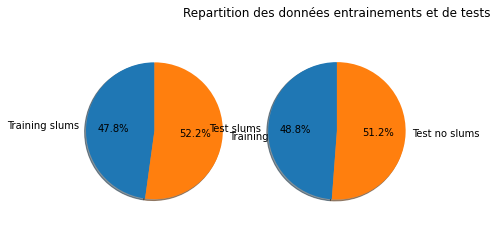

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 810. 2230. 2250. 2115.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_63681_1.tif'
[63681]
[1270. 1814. 1886. 2643.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_68234_1.tif'
[68234]
[1021. 2148. 2122. 2363.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_71136_1.tif'
[71136]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.42740908  -6.8574     -11.987901  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_66657_1.tif'
[66657]
[  0.5470565  -7.924084  -12.4186535]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_71184_1.tif'
[71184]
[ 0.51643956 -7.717322   -9.348995  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_69172_1.tif'
[69172]
Model is ready to run
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 10, 4)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10, 10, 3)]  0           []                               
                                                                                                  
 random_flip (RandomFlip)       (None, 10, 10, 4)    0   

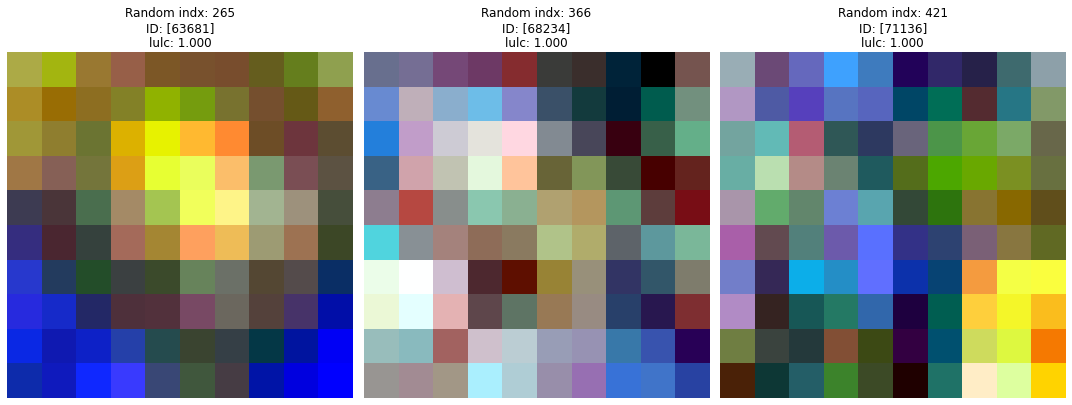

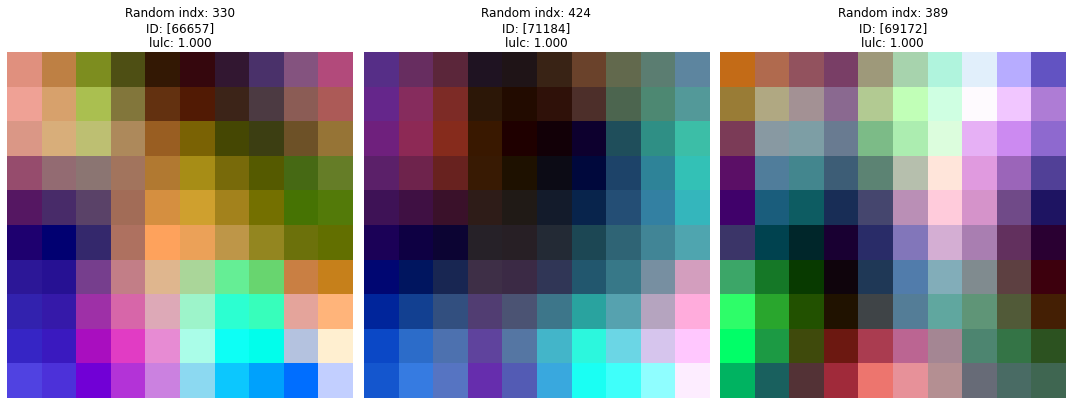

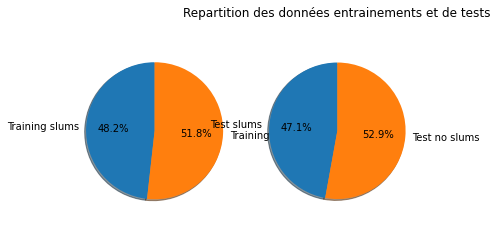

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1316. 1905. 1837. 2308.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_69943_1.tif'
[69943]
[1238. 1544. 1743. 2560.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_66708_1.tif'
[66708]
[ 752. 1470. 1762. 2412.]
b'Images/big_raster/tr_BNIR_patch/tr_BNIR_54032_1.tif'
[54032]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[  0.49967715  -6.1222553  -10.922736  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_60064_1.tif'
[60064]
[  0.70751464   0.82023734 -10.067889  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_52282_1.tif'
[52282]
[  0.38737407  -9.475293   -12.841023  ]
b'Images/big_raster/tr_ALLS1_patch/tr_ALLS1_69929_1.tif'
[69929]
Model is ready to run
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 10, 4)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10, 10, 3)]  0           []                               
                                                                                                  
 random_flip (RandomFlip)       (None, 10, 10, 4)  

In [ ]:
for path in range(3) :
    print(IMAGESTR[path])
    
    f = h5py.File(IMAGESG[path], 'r')
    S1_grid_id = np.array(f["id_sar"])          
    S2_grid_id = np.array(f["id_rgb"])                     
    S1_grid_path = f["patch_sar_path"]
    S2_grid_path = f["patch_rgb_path"]
    
    S1_grid_id = S1_grid_id.reshape(S1_grid_id.size,1)
    S2_grid_id = S2_grid_id.reshape(S2_grid_id.size,1)
    
    f = h5py.File(IMAGESTR[path], 'r')
    S1_patch_id = list(f["id_sar"])
    S2_patch_id = np.array(f["id_rgb"])
    S1_patch_lulc = list(f["lulc_sar"])
    S2_patch_lulc = np.array(f["lulc_rgb"])
    S1_patch_path = list(f["patch_sar_path"])
    S2_patch_path = list(f["patch_rgb_path"])
    
    stack = stackage(S1_grid_path)
    S1_stack_grid = normalise_01(stack)

    stack = stackage(S2_grid_path)
    S2_stack_grid = normalise_01(stack)
    
    print('Images are imported and normalised')
    
    HIST = []
    PRED = []
    EVAL = []
    
    
    PREDALL.append(S1_grid_id)
    
    for fold in range(5):
        patch_id_train = data.ID_train[fold][1:-1].split(",")
        patch_id_test = data.ID_val[fold][1:-1].split(",")
        patch_lulc_train = []

        i = 0
        for id in patch_id_train :
            index = S1_patch_id.index(int(id))
            patch_id_train[i] = int(id)
            lulc = S1_patch_lulc[index]
            patch_lulc_train.append(lulc)
            i += 1
        patch_lulc_test = []
        i = 0

        for id in patch_id_test :
            index = S1_patch_id.index(int(id))
            patch_id_test[i] = int(id)
            lulc = S1_patch_lulc[index]
            patch_lulc_test.append(lulc)
            i += 1

        patch_id_train = reshape(patch_id_train)
        patch_id_test = reshape(patch_id_test)
        patch_lulc_train = reshape(patch_lulc_train)
        patch_lulc_test = reshape(patch_lulc_test) 

        circle(patch_lulc_train,patch_lulc_test,'Repartition des données entrainements et de tests')

        stack_train, stack_test = assimilation(patch_id_train, patch_id_test, S2_patch_path)

        stack_sar_train, stack_sar_test = assimilation(patch_id_train, patch_id_test, S1_patch_path)
        
        from keras import backend as K
        K.clear_session()

        left_input_shape = (10,10,4)
        right_input_shape = (10,10,3)
        batch_size = 32
        kernel_size = 2
        dropout = 0.5 #0.5 for previous tests
        n_filters = 32
        
        print('Model is ready to run')

        history, predict, layers, model, evaluation = ymodel(left_input_shape,right_input_shape,batch_size,kernel_size,dropout,n_filters,stack_train,stack_test,stack_sar_train,stack_sar_test,fold)

        HIST.append(history)
        PRED.append(predict)
        EVAL.append(evaluation)
        
        print('End of the model for the data '+str(IMAGENAME[path])+' and the fold number : '+str(fold+1))

        make_csv(predict, S1_grid_id,'outputCSV/y_S1S2_KFOLD_'+str(IMAGENAME[path])+'_'+str(fold+1))
        
    HISTALL.append(HIST)
    PREDALL.append(PRED)
    EVALALL.append(EVAL)


## **Plotting accuracy, loss and prediction range**

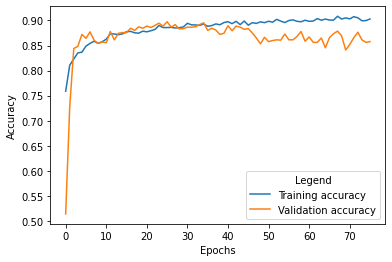

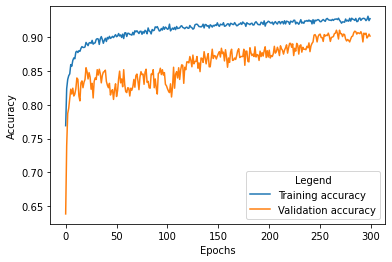

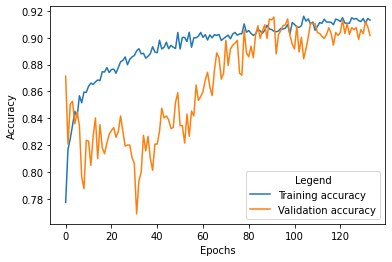

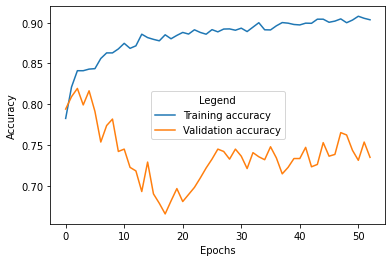

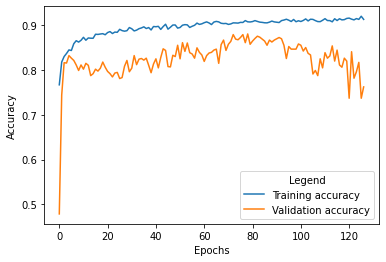

In [32]:
for history in HISTALL[0] :
    plt.plot(history.history["accuracy"])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Training accuracy','Validation accuracy'], title = "Legend")
    plt.show()

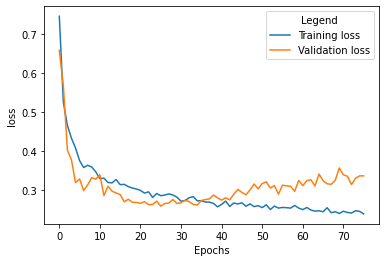

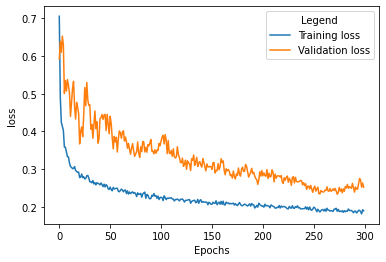

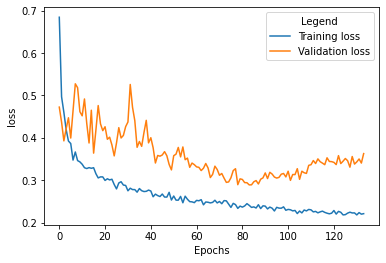

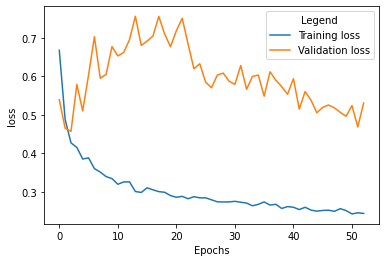

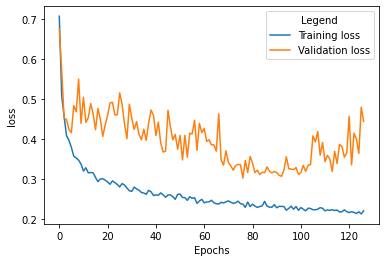

In [33]:
for history in HISTALL[0] :
    plt.plot(history.history["loss"])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.legend(['Training loss','Validation loss'], title = "Legend")
    plt.show()

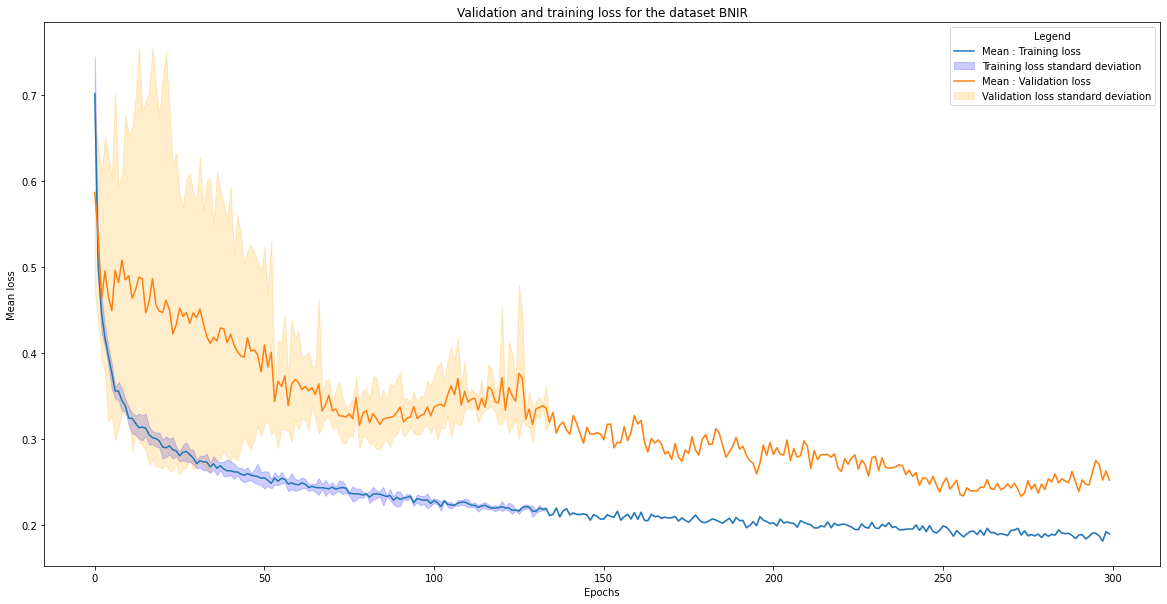

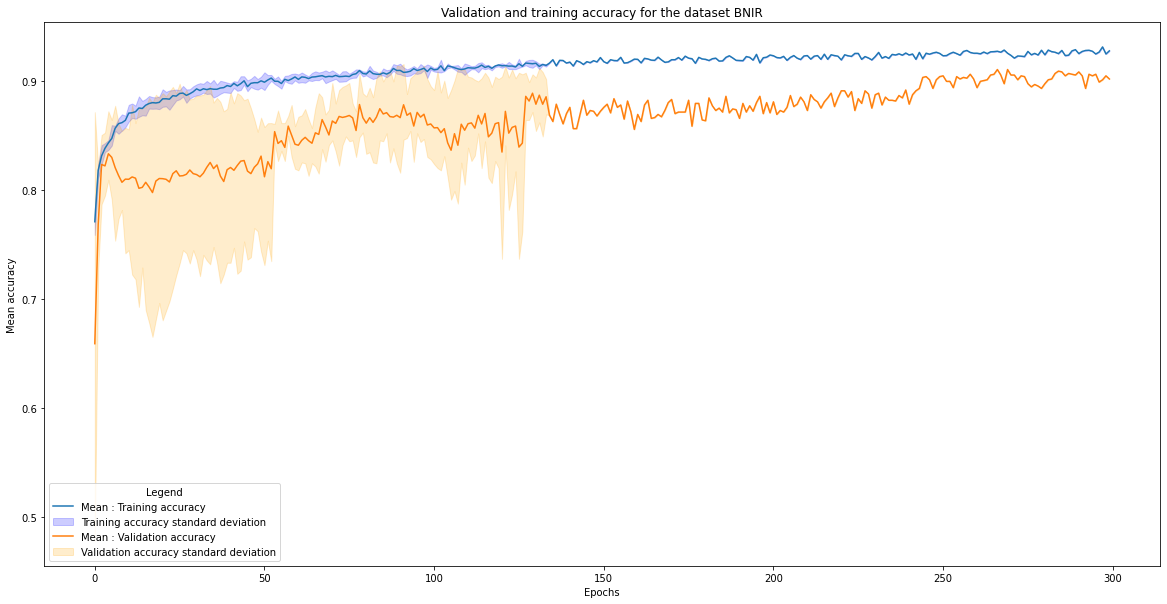

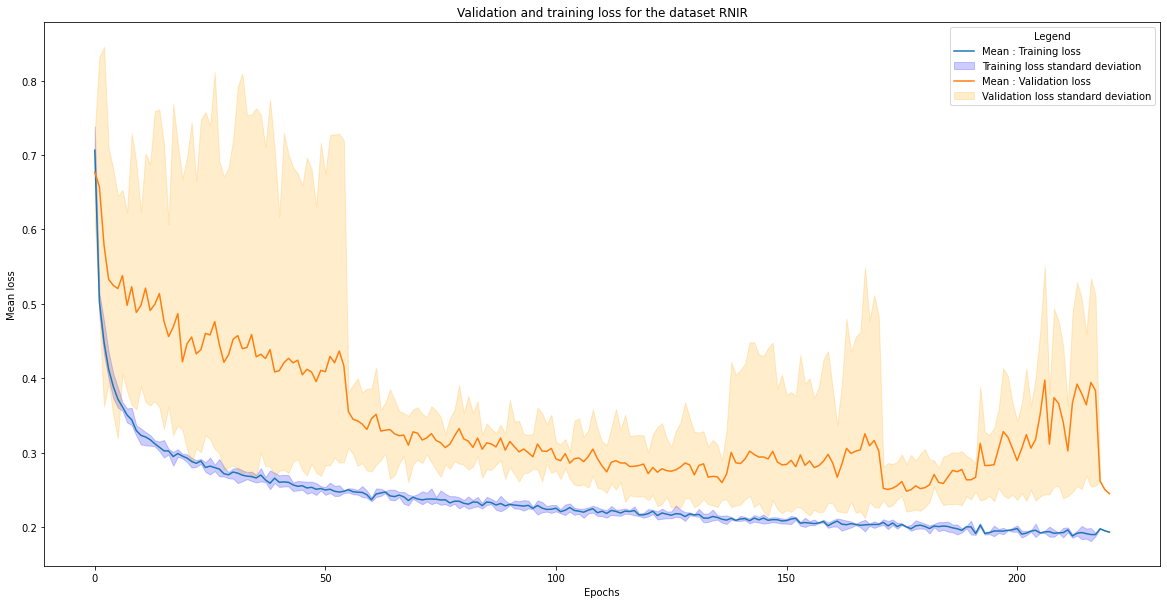

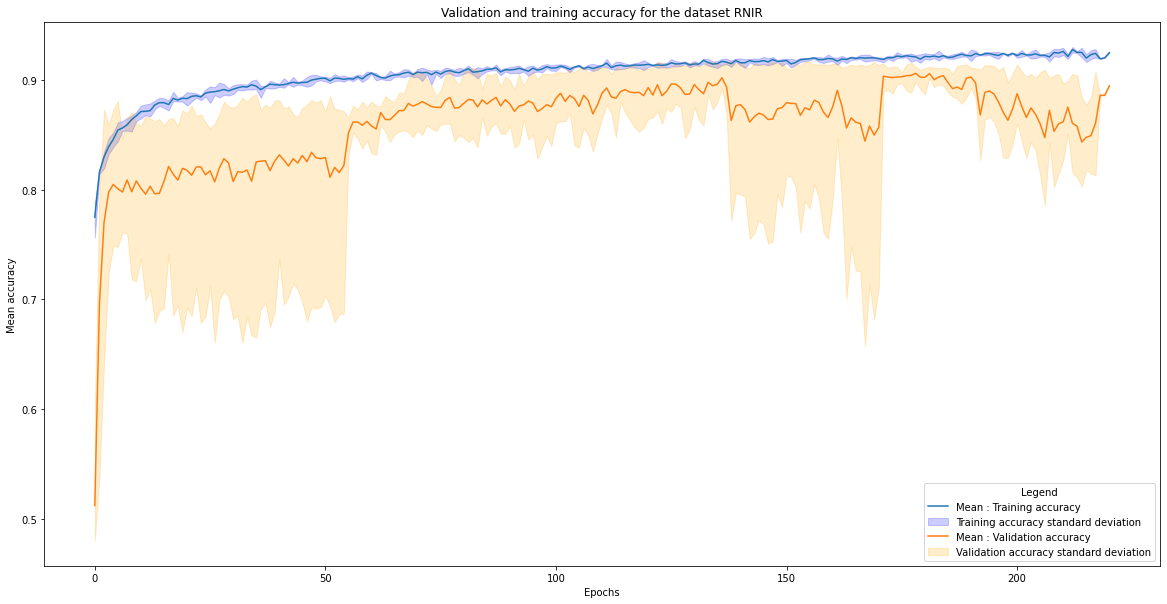

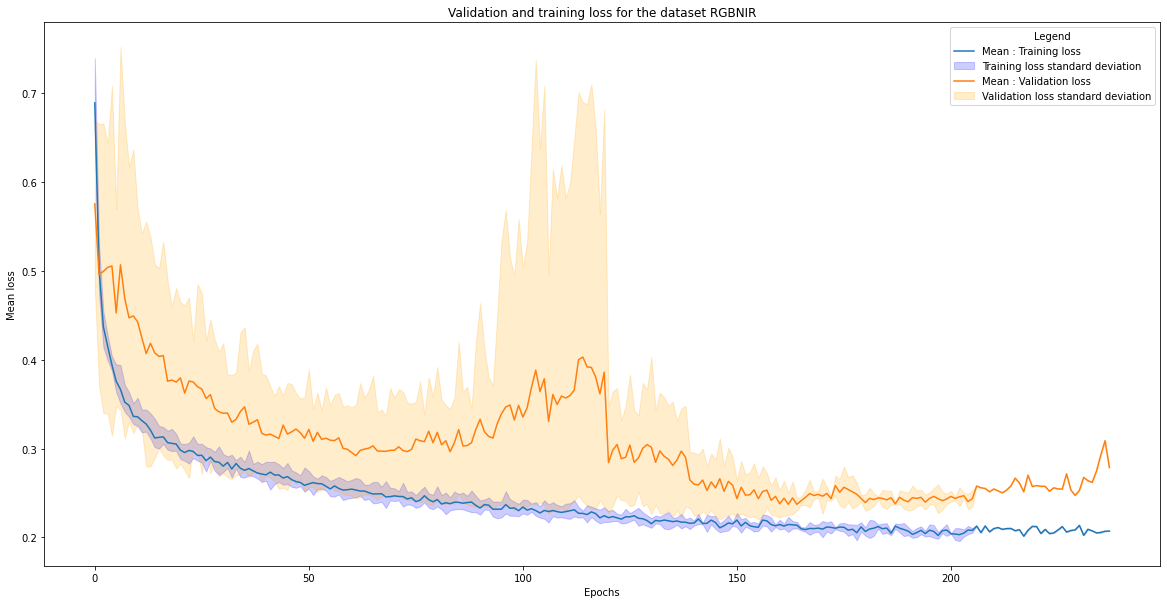

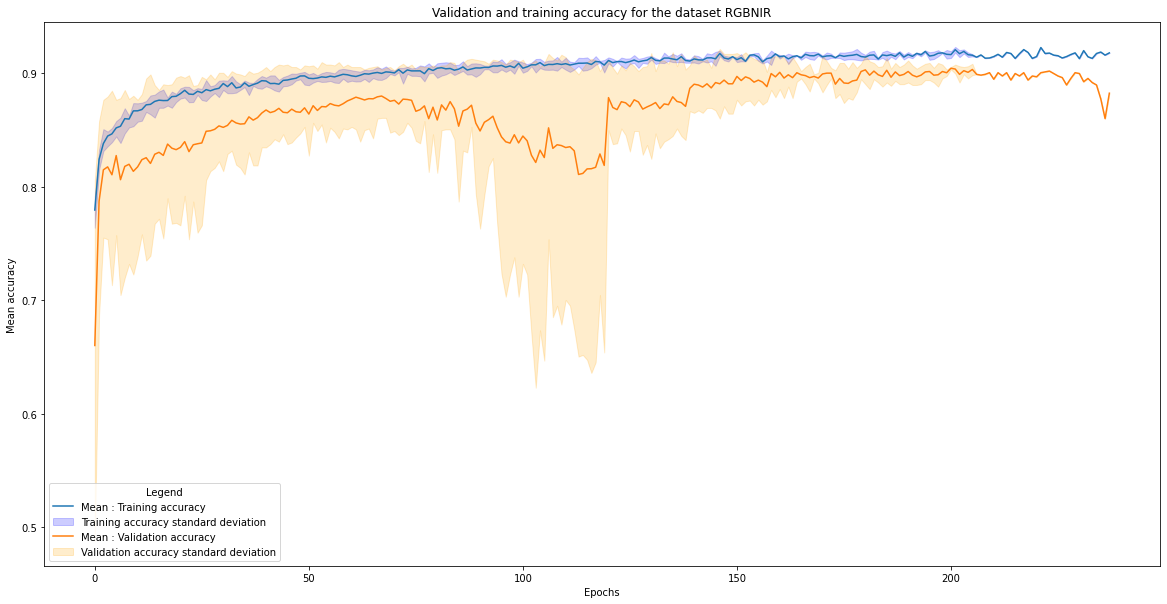

In [28]:
plotandcsv_history_kfold(HISTALL, 'ALL')

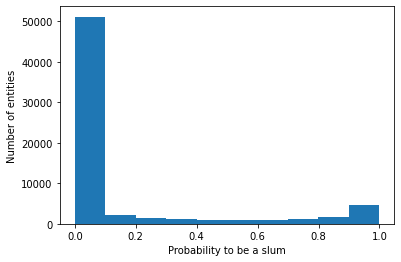

In [29]:
plt.hist(predict)
plt.xlabel('Probability to be a slum')
plt.ylabel('Number of entities')
plt.show()

## **Exporting accuracy** of each kfold's predictions

In [31]:
output_accuray = []
for i in range(len(EVALALL)) :
    EVAL = []
    somme = 0
    EVAL.append(IMAGENAME[i])
    for evaluation in EVALALL[i]: 
        EVAL.append(evaluation[1])
        somme += evaluation[1]
    std = np.std(EVAL[1:])
    EVAL.append(std)
    EVAL.append(somme/5)
    output_accuray.append(EVAL)
    
output_accuracy = np.array(output_accuray)

path_csv_kfold_output = '/home/jgovoort/outputCSV/YModelTest9_08.csv'
a = pd.DataFrame(output_accuracy, columns=['data','Kfold1','Kfold2','Kfold3','Kfold4','Kfold5','std','mean'])
a.to_csv(path_csv_kfold_output, index=False)

a

,data,Kfold1,Kfold2,Kfold3,Kfold4,Kfold5,std,mean
0,BNIR,0.8974729180335999,0.9104692935943604,0.9154624342918396,0.8193641901016235,0.8807803392410278,0.03480707572579483,0.8847098350524902
1,RNIR,0.9126353859901428,0.9054151773452759,0.9111271500587463,0.7789017558097839,0.9169074892997742,0.053175271047172464,0.8849973917007447
2,RGBNIR,0.9032490849494934,0.8844765424728394,0.8887283205986023,0.8641618490219116,0.9212427735328674,0.019095862422660422,0.8923717141151428


In [ ]:
import csv

NAME = ['BNIR','RNIR','RBGNIR']

CSV = []

for name in NAME :
    for i in range(1,6) :
        PROB = []
        PROB_id = []
        with open('outputCSV/y_S1S2_KFOLD_'+str(name)+'_'+str(i)+'.csv') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            PROB = []
            PROB_id = []
            for row in csv_reader:
                PROB.append(row[0])
                PROB_id.append(row[1])
                
    CSV.append(PROB)
    CSV.append(PROB_id)

    path_csv_kfold_output = '/home/jgovoort/outputCSV/MEAN_'+str(name)+'.csv'
    a = pd.DataFrame(output_accuracy, columns=['data','Kfold1','Kfold2','Kfold3','Kfold4','Kfold5','std','mean'])
    a.to_csv(path_csv_kfold_output, index=False)

0.03322613461096709
0.8057788862271519
0.8232369638696551
0.8327371771732354
0.8402520263840121
0.8458307354051128
0.8498014635907196
0.853542480228399
0.8565943622222951
0.8592196370557543
0.8616808322121222
0.8639123158205625
0.865503888688347
0.867423620910314
0.8689987858103895
0.8704755029042103
0.8718537721917763
0.8731335936730876
0.8745610868637811
0.8756276047648738
0.8768746103107669
0.8779411282118597
0.8792537656285893
0.8803530994651002
0.8815344731401569
0.8826009910412497
0.8835362452006694
0.8845371312309257
0.8856200570997276
0.8866045351622748
0.887605421192531
0.8884750434811144
0.889377481705116
0.8905096314770452
0.8915925573458472
0.8926426672792308
0.8935943294063597
0.8946772552751616
0.8957929970793818
0.8965477635940012
0.897614281495094
0.8984018639451318
0.8994847898139336
0.9004200439733535
0.9013881140681915
0.9021592885505201
0.9031273586453582
0.9041446526433236
0.9050634988350343
0.9061628326715453
0.9071309027663833
0.9078856692810029
0.908706067666458

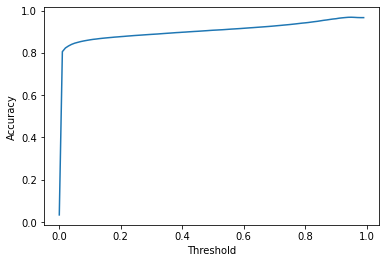

In [85]:
import csv
from sklearn.metrics import accuracy_score

VAL = []
VAL_id = []

with open('Images/test_sample/validation.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line = 0
    for row in csv_reader:
        if line >= 1 :
            VAL.append(float(row[2]))
            VAL_id.append(int(row[1]))
        line += 1


PROB = [None]*len(VAL)
PROB_id = [None]*len(VAL)

with open('outputCSV/y_S1S2_KFOLD_BNIR_1.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line = 0
    for row in csv_reader:
        if line >= 1 :
            prob_id = int(row[1])
            verif = prob_id in VAL_id
            if verif == True :
                index = VAL_id.index(prob_id)
                PROB[index]= float(row[0])
                PROB_id[index] = prob_id
        line += 1

        



        
listthres = list(np.arange(0, 1.0, 0.01))

TOTACC = []

for threshold in listthres :
    pred = np.asarray(PROB)
    binary = np.where(pred>=threshold,1,0)

    
    acc = accuracy_score(VAL, binary)
                
    print(acc)
    TOTACC.append(acc)
                 
plt.plot(listthres,TOTACC)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
#plt.title('Validation and training accuracy for the dataset '+str(IMAGENAME[idx]))
#plt.legend(['Mean : Training accuracy','Training accuracy standard deviation','Mean : Validation accuracy', 'Validation accuracy standard deviation'], title = "Legend")
plt.show()

In [ ]:
TOTACC = []



plt.plot(listthres,TOTACC)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
#plt.title('Validation and training accuracy for the dataset '+str(IMAGENAME[idx]))
#plt.legend(['Mean : Training accuracy','Training accuracy standard deviation','Mean : Validation accuracy', 'Validation accuracy standard deviation'], title = "Legend")
plt.show()

In [78]:
for i in range(3) :
    path_csv_kfold_output = '/home/jgovoort/outputCSV/YModel'+str(IMAGENAME[i])+'8_08.csv'
    test = np.array(PREDALL)
    test = test[i,:,:,0]
    print(test.shape)
    test = test.transpose()

    a = pd.DataFrame(test, columns=['Kfold1','Kfold2','Kfold3','Kfold4','Kfold5','Kfold6','Kfold7','Kfold8','Kfold9','Kfold10'])
    a.to_csv(path_csv_kfold_output, index=False)

    a

(10, 66399)
(10, 66399)
(10, 66399)


## Garbage zone

In [ ]:
from osgeo import ogr

diff = []
diff.append(['id','diff'])
mach_res = ogr.Open('CLUSTERS/nairobi_grid100_clust_morpho_10pc_10cl.shp')
mach_layer = mach_res.GetLayer()
for mach_patch in mach_layer :
    probstab = mach_patch.GetField('probstab')
    mach_id = mach_patch.GetField('id')
    index = S1_grid_id.index(mach_id)
    if probstab != None :
        line = [int(mach_id),predict[index,0] - probstab]
        diff.append(line)
    else :
        line = [int(mach_id),None]
        diff.append(line)

In [ ]:
import csv

name = 'machVSdeep2'

with open(str(name)+'.csv','w') as file :
    write = csv.writer(file)
    write.writerows(diff)

In [ ]:
print(diff)

In [ ]:
import os, signal

os.kill(os.getpid() , signal.SIGKILL)